Stores

Anonymized information about the 45 stores, indicating the type and size of store
Features

Contains additional data related to the store, department, and regional activity for the given dates.

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

Sales

Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week
    
    
    
Tasks: 
1. predict Fuel_Price for 1 month using all stores
2. predict Fuel_Price for 1 month using all data for new (unknown) store

In [1]:
#!pip3 install category_encoders

In [2]:
#!pip3 install xgboost

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [75]:
import joblib
import os
from pathlib import Path

In [76]:
plt.style.use('ggplot')

In [77]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')

In [78]:
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [79]:
print(features.shape)
print(sales.shape)
print(stores.shape)

print(sales[0:1].Date, sales[-1:].Date)

print(features[0:1].Date, features[-1:].Date)

(8190, 12)
(421570, 5)
(45, 3)
0   2010-05-02
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2010-05-02
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


# 1. Merge the data in a unique DataFrame

In [9]:
df=pd.merge(sales, features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df, stores, on=['Store'], how='left')

df=df.fillna(0)
df['Temperature'] = (df['Temperature'] - 32) * 5./9.

types_encoded, types =df['Type'].factorize()
df['Type'] = types_encoded

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315
1,1,1,2010-12-02,46039.49,True,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315
2,1,1,2010-02-19,41595.55,False,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,151315
3,1,1,2010-02-26,19403.54,False,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,151315
4,1,1,2010-05-03,21827.90,False,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,151315


# 2. Check features

In [10]:
# Min date
df.Date.min()

Timestamp('2010-01-10 00:00:00')

In [11]:
# Max date
df.Date.max()

Timestamp('2012-12-10 00:00:00')

In [12]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.589912,136727.915739
std,12.785297,30.492054,22711.183519,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328
min,1.000000,1.000000,-4988.940000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.000000,34875.000000
25%,11.000000,18.000000,2079.650000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.000000,93638.000000
50%,22.000000,37.000000,7612.030000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.000000,140167.000000
75%,33.000000,74.000000,20205.852500,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,1.000000,202505.000000
max,45.000000,99.000000,693099.360000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2.000000,219622.000000


In [13]:
df_numeric = df[['Temperature','Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment']]

array([[<AxesSubplot:xlabel='Temperature', ylabel='Temperature'>,
        <AxesSubplot:xlabel='Weekly_Sales', ylabel='Temperature'>,
        <AxesSubplot:xlabel='Fuel_Price', ylabel='Temperature'>,
        <AxesSubplot:xlabel='CPI', ylabel='Temperature'>,
        <AxesSubplot:xlabel='Unemployment', ylabel='Temperature'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='Weekly_Sales'>,
        <AxesSubplot:xlabel='Weekly_Sales', ylabel='Weekly_Sales'>,
        <AxesSubplot:xlabel='Fuel_Price', ylabel='Weekly_Sales'>,
        <AxesSubplot:xlabel='CPI', ylabel='Weekly_Sales'>,
        <AxesSubplot:xlabel='Unemployment', ylabel='Weekly_Sales'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='Fuel_Price'>,
        <AxesSubplot:xlabel='Weekly_Sales', ylabel='Fuel_Price'>,
        <AxesSubplot:xlabel='Fuel_Price', ylabel='Fuel_Price'>,
        <AxesSubplot:xlabel='CPI', ylabel='Fuel_Price'>,
        <AxesSubplot:xlabel='Unemployment', ylabel='Fuel_Price'>],
       [<AxesSubplot:xlabel=

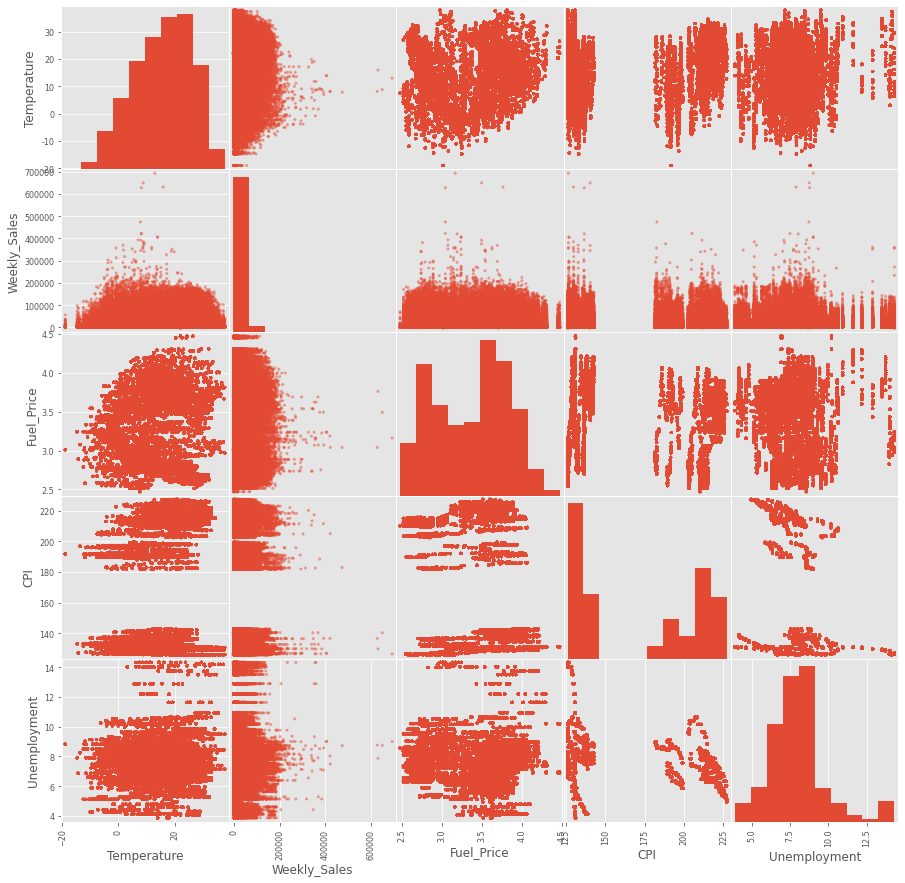

In [14]:
pd.plotting.scatter_matrix(df_numeric, figsize=(15, 15))

As we see fuel price is bimodal destibuted -> can try to predict 

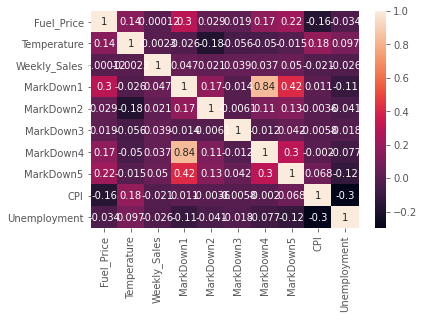

In [15]:
df_numeric_corr = df[['Fuel_Price', 'Temperature','Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']]
corrMatrix = df_numeric_corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

corrmatrix shows that we should delete some features, such as markdown4 for example

In [16]:
# std, mean, median Fuel_Price by stores
tab = pd.pivot_table(data=df, index='Store', values=['Fuel_Price'],
                     aggfunc={'Fuel_Price':['std', 'mean', 'median']}).sort_values([
                                                         ('Fuel_Price','std'), ('Fuel_Price','mean'), ('Fuel_Price','median')], ascending=False)
tab = tab.reset_index()
tab

Store Fuel_Price                 
               mean median       std
0     22   3.441012  3.577  0.453997
1     29   3.441940  3.577  0.453284
2     23   3.443894  3.577  0.453046
3     18   3.444138  3.577  0.452860
4     26   3.443883  3.577  0.452699
5     40   3.443478  3.577  0.452614
6     27   3.579829  3.722  0.452550
7     19   3.577479  3.722  0.452525
8     15   3.578823  3.722  0.452210
9     24   3.579467  3.722  0.452172
10    12   3.607416  3.705  0.446452
11    10   3.572490  3.675  0.446255
12    28   3.606599  3.705  0.446248
13    38   3.617363  3.722  0.445569
14    42   3.590825  3.694  0.445322
15    36   3.210664  3.282  0.444624
16    33   3.589131  3.694  0.442611
17    14   3.417702  3.541  0.441885
18    25   3.418024  3.541  0.441238
19    45   3.419065  3.541  0.441116
20    20   3.418723  3.541  0.441082
21    35   3.418559  3.541  0.441046
22    32   3.240426  3.372  0.428652
23     7   3.239985  3.372  0.428617
24    41   3.244663  3.372  0.427903
25    16   3.248837  3.378  0.427780
26    43   3.218109  3.290  0.426352
27    30   3.225819  3.297  0.426154
28    31   3.218950  3.290  0.426126
29    39   3.219481  3.290  0.426057
30     8   3.219254  3.290  0.425846
31     1   3.218811  3.290  0.425663
32     6   3.220977  3.290  0.425590
33     2   3.219898  3.290  0.425544
34     3   3.219112  3.290  0.425543
35    21   3.219385  3.290  0.425241
36    11   3.222245  3.290  0.425211
37     5   3.220912  3.290  0.425141
38     9   3.223913  3.297  0.424240
39    37   3.233473  3.308  0.423893
40    34   3.214008  3.286  0.415624
41     4   3.216237  3.290  0.415560
42    13   3.284581  3.380  0.391516
43    17   3.288495  3.380  0.391323
44    44   3.294224  3.389  0.390882

In [17]:
# std, mean, median Fuel_Price by Dept
tab = pd.pivot_table(data=df, index='Dept', values=['Fuel_Price'],
                     aggfunc={'Fuel_Price':['std', 'mean', 'median']}).sort_values([
                                                         ('Fuel_Price','std'), ('Fuel_Price','mean'), ('Fuel_Price','median')], ascending=False)
tab = tab.reset_index()
tab

Dept Fuel_Price                  
              mean  median       std
0    39   3.560125  4.0485  0.701559
1    78   3.182128  2.9820  0.469811
2    47   3.287125  3.2645  0.464176
3    54   3.330277  3.4000  0.462586
4    59   3.344855  3.4130  0.462488
..  ...        ...     ...       ...
76   48   3.355615  3.4750  0.419945
77   65   3.216972  3.2900  0.416967
78   43   3.514833  3.5325  0.372962
79   99   3.592702  3.6170  0.307168
80   77   3.509033  3.4925  0.281020

[81 rows x 4 columns]

In [18]:
# std, mean, median Fuel_Price by Type
tab = pd.pivot_table(data=df, index='Type', values=['Fuel_Price'],
                     aggfunc={'Fuel_Price':['std', 'mean', 'median']}).sort_values([
                                                         ('Fuel_Price','std'), ('Fuel_Price','mean'), ('Fuel_Price','median')], ascending=False)
tab = tab.reset_index()
tab

Type Fuel_Price                 
             mean median       std
0    2   3.364654  3.417  0.460287
1    0   3.343999  3.417  0.458702
2    1   3.382523  3.494  0.456880

In [19]:
df.Store.value_counts()

13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: Store, dtype: int64

In [20]:
df[df.Store == 1].tail(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
10239,1,99,2012-08-31,20.06,False,26.938889,3.638,21442.73,102.32,21.70,13209.64,3032.96,222.305481,6.908,0,151315
10240,1,99,2012-07-09,0.05,True,28.866667,3.730,5204.68,35.74,50.94,4120.32,2737.17,222.439015,6.908,0,151315
10241,1,99,2012-09-14,0.03,False,23.872222,3.717,17212.52,7.00,18.79,1523.11,7992.72,222.582019,6.908,0,151315
10242,1,99,2012-05-10,635.00,False,20.305556,3.617,8077.89,0.00,18.22,3617.43,3626.14,223.181477,6.573,0,151315
10243,1,99,2012-12-10,80.00,False,17.216667,3.601,2086.18,0.00,8.11,602.36,5926.45,223.381296,6.573,0,151315


# Gain some graphical insight

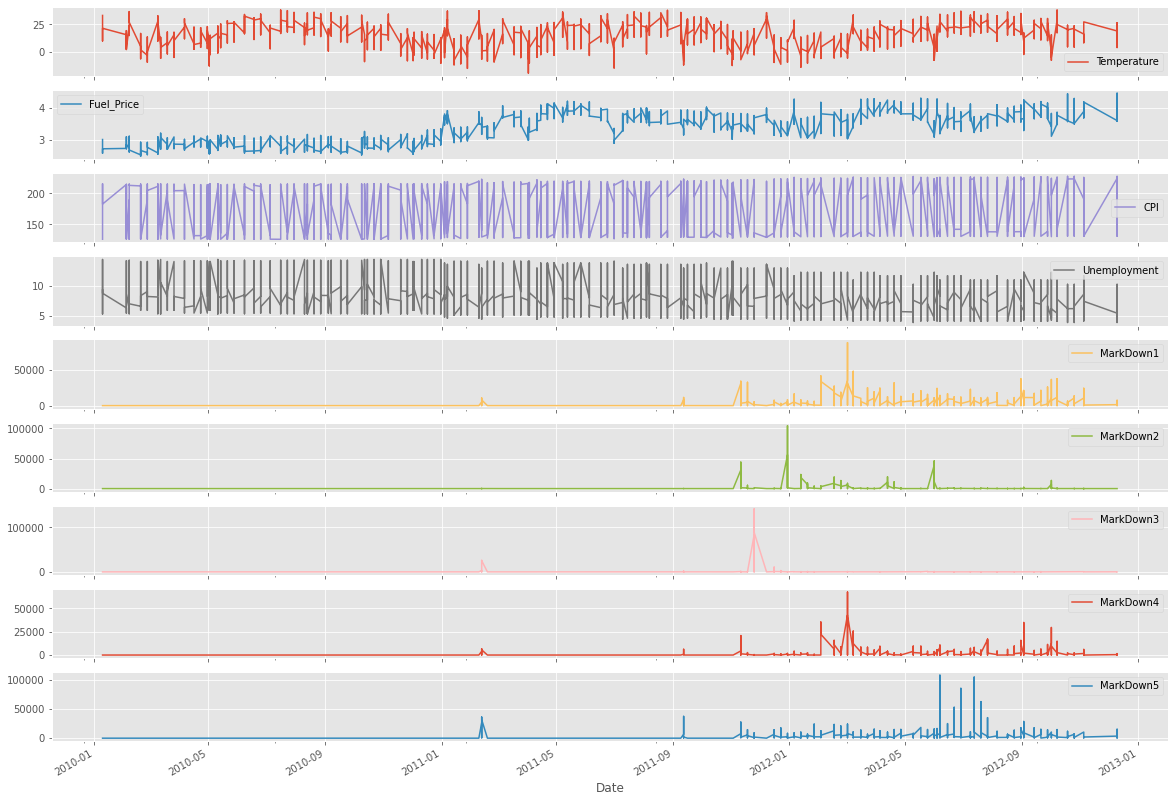

In [21]:
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

MarkDown3 is zero except for a few dates? 

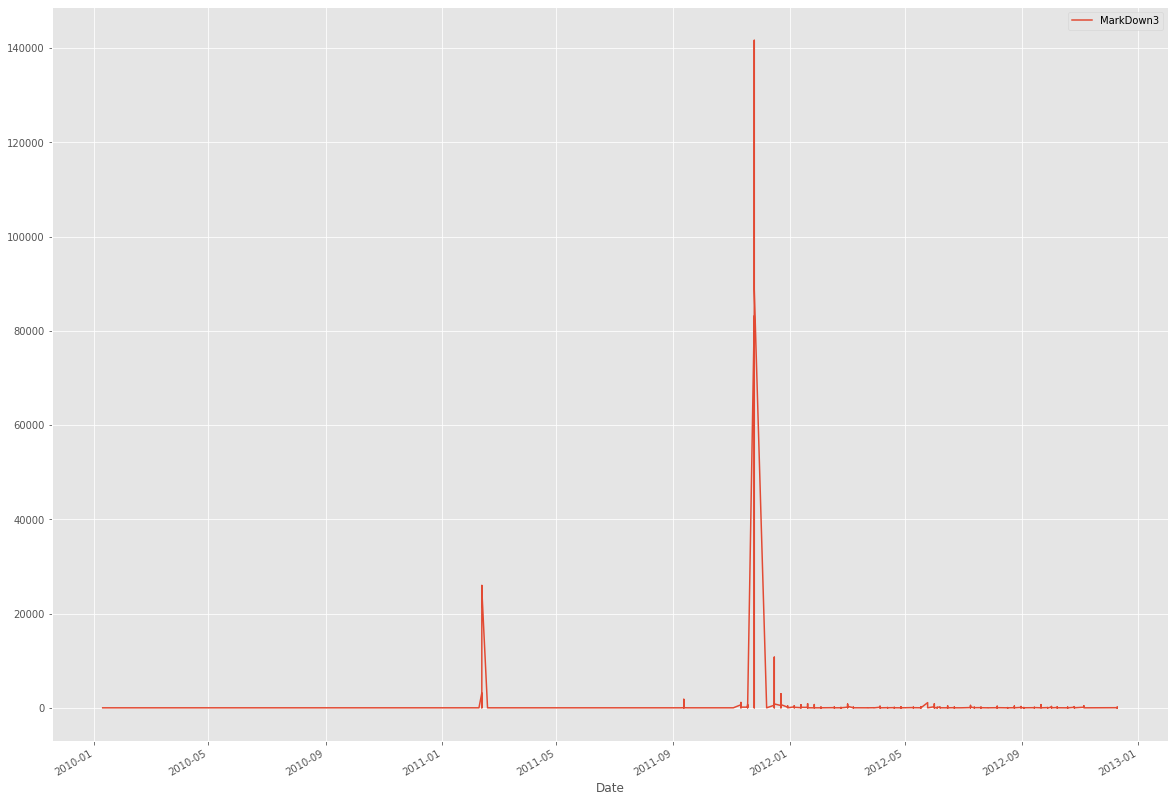

In [22]:
df[['Date', 'MarkDown3']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

Sum the fuel price from every shop to get the total weekly volume of the retail chain 

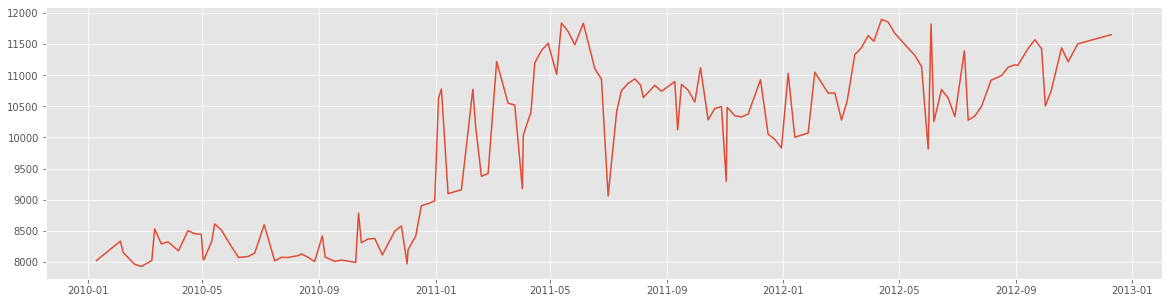

In [23]:
df_fuel_price_sum = df.groupby(by=['Date'], as_index=False)['Fuel_Price'].sum()

plt.figure(figsize=(20,5))
plt.plot(df_fuel_price_sum.Date, df_fuel_price_sum.Fuel_Price)
plt.show()

As we can see fuel price is increased from 2011-01 for all stores

Sum the Weekly_Sales from every shop to get the total weekly volume of the retail chain 

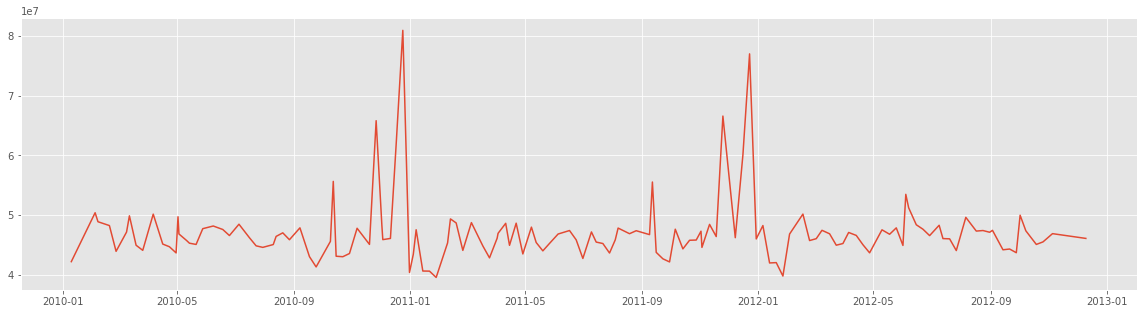

In [24]:
df_weekly_sales_sum = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

plt.figure(figsize=(20,5))
plt.plot(df_weekly_sales_sum.Date, df_weekly_sales_sum.Weekly_Sales)
plt.show()

In [25]:
# Top performing type of stores
df_types = df.groupby(by=['Type'], as_index=False)['Fuel_Price'].sum()
df_types.sort_values('Fuel_Price', ascending=False)

,Type,Fuel_Price
0,0,720558.149
1,1,553025.656
2,2,143324.148


In [26]:
# Top performing stores
df_top_stores = df.groupby(by=['Store'], as_index=False)['Fuel_Price'].sum()
df_top_stores.sort_values('Fuel_Price', ascending=False)[:10]

,Store,Fuel_Price
9,10,36850.231
23,24,36610.785
26,27,36603.753
27,28,36473.537
18,19,36304.259
14,15,35433.927
11,12,35009.971
19,20,34918.832
22,23,34611.132
39,40,34493.315


In [27]:
# Low performing  stores
df_top_stores = df.groupby(by=['Store'], as_index=False)['Fuel_Price'].sum()
df_top_stores.sort_values('Fuel_Price', ascending=True)[:10]

,Store,Fuel_Price
35,36,19976.749
42,43,21725.453
29,30,23083.964
32,33,23282.695
36,37,23300.409
43,44,23616.290
41,42,24967.006
37,38,26631.026
8,9,28586.439
4,5,28984.988


In [28]:
# Fuel_price by dates for low perf store
df_store = df[df.Store == 36]
df_top_stores = df_store.groupby(by=['Date'], as_index=False)['Fuel_Price'].mean()
df_top_stores.sort_values('Date', ascending=False)

,Date,Fuel_Price
142,2012-12-10,3.576
141,2012-11-05,3.764
140,2012-10-26,3.494
139,2012-10-19,3.570
138,2012-10-08,3.490
...,...,...
4,2010-02-26,2.520
3,2010-02-19,2.472
2,2010-02-07,2.606
1,2010-02-04,2.708


# Check data and features

In [29]:
# Unique values
tab_info = pd.DataFrame([len(df[column].unique())for column in df.columns]).T.rename(index={0:'unique values'})
tab_info.columns = df.columns
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
unique values,45,81,143,359464,2,3528,892,2278,1499,1662,1945,2294,2145,349,3,40


In [30]:
# check for null values
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Forecast of the Fuel Price using all Stores

In [31]:
num_features = ['Temperature','Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5', 'CPI', 'Unemployment']
target_encoding_features = ['Store', 'Dept', 'Type']
target = 'Fuel_Price'

feature_list = num_features + target_encoding_features

In [32]:
thr_splt = '2012-10-01'

In [33]:
train_idx = df.query('Date<@thr_splt').index
test_idx = df.query('Date>=@thr_splt').index

X_train = df.loc[train_idx, feature_list]
X_test = df.loc[test_idx, feature_list]

y_train = df.loc[train_idx, target]
y_test = df.loc[test_idx, target]

In [34]:
ct = ColumnTransformer([("scaler",  MinMaxScaler(), num_features), 
                            ("target_encoding", ce.TargetEncoder(cols=target_encoding_features, smoothing=100,
                                                                 min_samples_leaf=10), target_encoding_features)])

X_train = ct.fit_transform(X_train, y = y_train)
X_test = ct.transform(X_test)

/home/yur/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [35]:
new_features_name = num_features + target_encoding_features
new_features_name

['Temperature',
 'Weekly_Sales',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Store',
 'Dept',
 'Type']

## Base model

In [36]:
# LASSO and RIDGE Regressions

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-5,3,20)

clf = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(X_train, y_train)
optlamGSCV_R = clf.best_estimator_.alpha
print('Optimum regularization parameter (Ridge):', optlamGSCV_R)

clf = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(X_train, y_train)
optlamGSCV_L= clf.best_estimator_.alpha
print('Optimum regularization parameter (Lasso):', optlamGSCV_L)

Optimum regularization parameter (Ridge): 143.844988828766
Optimum regularization parameter (Lasso): 0.0004832930238571752


In [37]:
from sklearn import metrics

lasso = linear_model.Lasso(alpha = optlamGSCV_L) 
lasso.fit(X_train, y_train)
print('RMSE value of the Lasso model is: ', np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))))
print('MAE value of the lasso model is: ', mean_absolute_error(y_test, lasso.predict(X_test)))

RMSE value of the Lasso model is:  0.38111879270973675
MAE value of the lasso model is:  0.3172798176056313


/home/yur/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


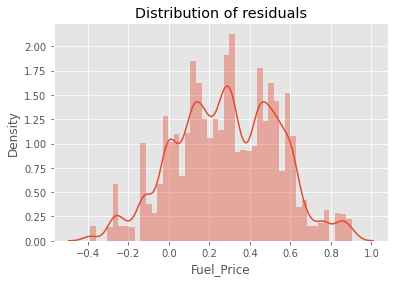

In [38]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - lasso.predict(X_test))
plt.title('Distribution of residuals');

## Base model. Fuel Price for one store using all others

In [39]:
_train = df[df.Store != 20]
_test = df[df.Store == 20]
_test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
187335,20,1,2010-05-02,46021.21,False,-3.377778,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,0,203742
187336,20,1,2010-12-02,52734.17,True,-5.488889,2.773,0.0,0.0,0.0,0.0,0.0,204.385747,8.187,0,203742
187337,20,1,2010-02-19,55649.79,False,-3.650000,2.745,0.0,0.0,0.0,0.0,0.0,204.432100,8.187,0,203742
187338,20,1,2010-02-26,36805.42,False,0.177778,2.754,0.0,0.0,0.0,0.0,0.0,204.463087,8.187,0,203742
187339,20,1,2010-05-03,41206.78,False,-0.138889,2.777,0.0,0.0,0.0,0.0,0.0,204.494073,8.187,0,203742


In [40]:
train_idx = _train.query('Date<@thr_splt').index
test_idx = _test.query('Date>=@thr_splt').index

X_train = _train.loc[train_idx, feature_list]
X_test = _test.loc[test_idx, feature_list]

y_train = _train.loc[train_idx, target]
y_test = _test.loc[test_idx, target]

In [41]:
ct = ColumnTransformer([("scaler",  MinMaxScaler(), num_features), 
                            ("target_encoding", ce.TargetEncoder(cols=target_encoding_features, smoothing=100,
                                                                 min_samples_leaf=10), target_encoding_features)])

X_train = ct.fit_transform(X_train, y = y_train)
X_test = ct.transform(X_test)
new_features_name = num_features + target_encoding_features

/home/yur/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [42]:
# LASSO 
clf = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(X_train, y_train)
optlamGSCV_L= clf.best_estimator_.alpha
print('Optimum regularization parameter (Lasso):', optlamGSCV_L)

Optimum regularization parameter (Lasso): 0.0004832930238571752


In [43]:
lasso = linear_model.Lasso(alpha = optlamGSCV_L) 
lasso.fit(X_train, y_train)
print('RMSE value of the Lasso model is: ', np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))))
print('MAE value of the lasso model is: ', mean_absolute_error(y_test, lasso.predict(X_test)))

RMSE value of the Lasso model is:  0.37733625123424025
MAE value of the lasso model is:  0.31745694269833985


## XGB model

In [44]:
X_train = xgb.DMatrix(X_train, label=y_train, feature_names=new_features_name)
X_test = xgb.DMatrix(X_test, label=y_test, feature_names=new_features_name)

In [45]:
param = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror'}
param['eval_metric'] = ['rmse']
evallist = [(X_test, 'eval', 'val')]

In [46]:
num_round = 75
bst = xgb.train(param, X_train, num_round, evallist)

[0]	eval-rmse:3.02333
[1]	eval-rmse:2.72786
[2]	eval-rmse:2.46003
[3]	eval-rmse:2.22011
[4]	eval-rmse:2.00315
[5]	eval-rmse:1.80524
[6]	eval-rmse:1.63022
[7]	eval-rmse:1.46694
[8]	eval-rmse:1.33007
[9]	eval-rmse:1.21006
[10]	eval-rmse:1.10085
[11]	eval-rmse:0.99875
[12]	eval-rmse:0.90165
[13]	eval-rmse:0.82138
[14]	eval-rmse:0.74235
[15]	eval-rmse:0.67490
[16]	eval-rmse:0.61869
[17]	eval-rmse:0.56583
[18]	eval-rmse:0.52328
[19]	eval-rmse:0.48604
[20]	eval-rmse:0.44828
[21]	eval-rmse:0.41785
[22]	eval-rmse:0.39088
[23]	eval-rmse:0.36673
[24]	eval-rmse:0.32574
[25]	eval-rmse:0.30629
[26]	eval-rmse:0.27220
[27]	eval-rmse:0.25582
[28]	eval-rmse:0.23912
[29]	eval-rmse:0.22505
[30]	eval-rmse:0.21647
[31]	eval-rmse:0.20988
[32]	eval-rmse:0.20049
[33]	eval-rmse:0.19235
[34]	eval-rmse:0.18543
[35]	eval-rmse:0.16482
[36]	eval-rmse:0.15822
[37]	eval-rmse:0.15412
[38]	eval-rmse:0.14865
[39]	eval-rmse:0.14660
[40]	eval-rmse:0.14345
[41]	eval-rmse:0.13991
[42]	eval-rmse:0.13711
[43]	eval-rmse:0.1280

In [47]:
bst.save_model('xgboost.model')
ypred = bst.predict(X_test)

# Evaluation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

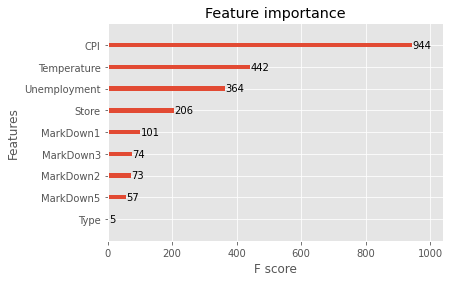

In [48]:
xgb.plot_importance(bst)

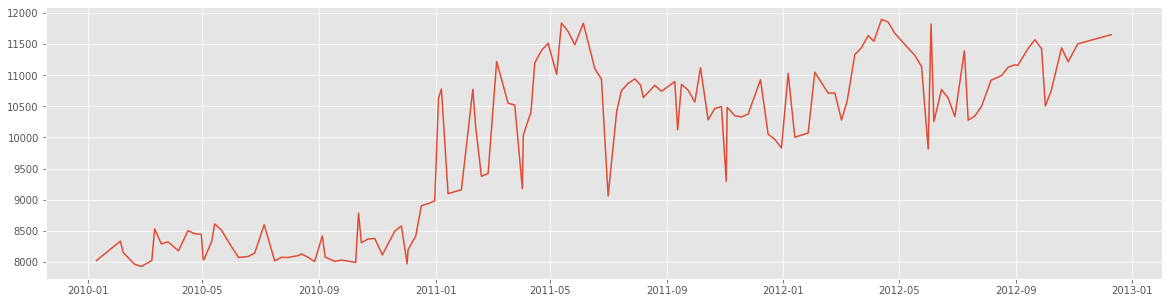

In [49]:
df_fuel_price_sum = df.groupby(by=['Date'], as_index=False)['Fuel_Price'].sum()
df_CPI_sum = df.groupby(by=['Date'], as_index=False)['CPI'].sum()


plt.figure(figsize=(20,5))
plt.plot(df_fuel_price_sum.Date, df_fuel_price_sum.Fuel_Price)
plt.show()

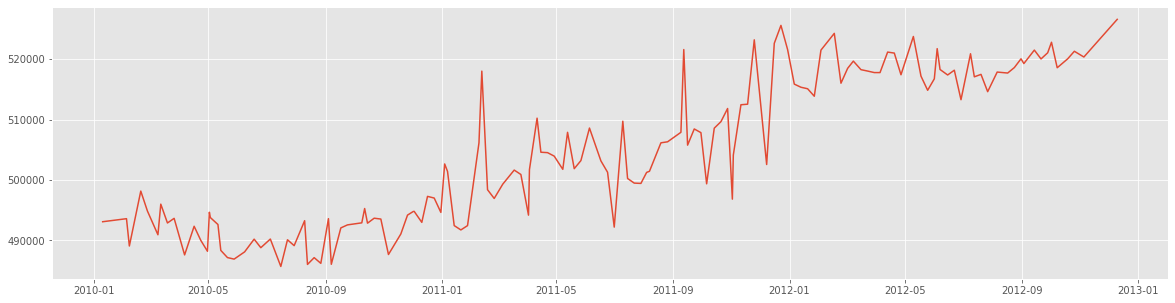

In [50]:
df_CPI_sum = df.groupby(by=['Date'], as_index=False)['CPI'].sum()


plt.figure(figsize=(20,5))
plt.plot(df_fuel_price_sum.Date, df_CPI_sum.CPI)
plt.show()

In [51]:
#MAE
mae = mean_absolute_error(y_test, ypred)
print(f'Mean absolute error: {mae}')

Mean absolute error: 0.07781434075920661


In [52]:
#RMSE
mse = mean_squared_error(y_test,ypred)
print(f'Root mean squared error: {np.sqrt(mse)}')

Root mean squared error: 0.10345553904740348


In [53]:
#RMSE Naive aproach
np.sqrt(np.sum((ypred-np.mean(y_test))**2)/len(ypred))

0.19493414506762066

As we can see, errors much more lower than base model

## Error destribution through stores

In [54]:
test_df = df.loc[test_idx, :]
test_df['ypred'] = ypred
test_df['mae'] = np.abs(test_df['Fuel_Price'] - test_df['ypred'])
test_df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,ypred,mae
187440,20,1,2012-10-02,48824.09,True,0.816667,3.640,9804.00,13171.55,132.42,16864.33,7535.63,213.118614,6.961,0,203742,3.464396,0.175604
187453,20,1,2012-11-05,29777.72,False,17.327778,3.889,17598.62,0.00,19.51,2889.48,3242.44,214.531910,7.139,0,203742,3.871078,0.017922
187466,20,1,2012-10-08,29240.93,False,24.111111,3.722,16845.14,156.18,12.47,6921.28,6346.44,214.748460,7.280,0,203742,3.594522,0.127478
187475,20,1,2012-12-10,41280.48,False,8.444444,4.000,2449.31,0.00,35.08,1019.90,9743.56,216.115057,7.293,0,203742,3.873509,0.126491
187476,20,1,2012-10-19,40958.43,False,13.477778,3.969,4174.31,0.00,15.84,838.05,3838.56,216.146470,7.293,0,203742,3.956704,0.012296
187477,20,1,2012-10-26,55623.24,False,15.577778,3.882,10813.19,22.33,102.91,867.39,1671.76,216.151590,7.293,0,203742,3.879032,0.002968
187583,20,2,2012-10-02,86996.44,True,0.816667,3.640,9804.00,13171.55,132.42,16864.33,7535.63,213.118614,6.961,0,203742,3.464396,0.175604
187596,20,2,2012-11-05,76679.80,False,17.327778,3.889,17598.62,0.00,19.51,2889.48,3242.44,214.531910,7.139,0,203742,3.871078,0.017922
187609,20,2,2012-10-08,84627.69,False,24.111111,3.722,16845.14,156.18,12.47,6921.28,6346.44,214.748460,7.280,0,203742,3.594522,0.127478
187618,20,2,2012-12-10,75563.24,False,8.444444,4.000,2449.31,0.00,35.08,1019.90,9743.56,216.115057,7.293,0,203742,3.873509,0.126491


### Errors for each Store

In [55]:
tab = pd.pivot_table(data=test_df, index='Store', values=['Weekly_Sales','mae', 'Fuel_Price'],
                     aggfunc={'Weekly_Sales':'sum', 'mae':['count','mean'], 'Fuel_Price':'mean'}).sort_values([
                                                         ('Weekly_Sales','sum'), ('mae','count'), ('mae','count')], ascending=False)
tab = tab.reset_index()
tab.columns = ['Store', 'mean_Fuel_Price', 'Weekly_Sales', 'counter', 'mae']
tab['mae/mean_FP'] = tab['mae']/tab['mean_Fuel_Price']*100
tab

,Store,mean_Fuel_Price,Weekly_Sales,counter,mae,mae/mean_FP
0,20,3.850118,12969286.18,432,0.077814,2.02109


# Forecast of the Fuel Price for one store using all others 

In [56]:
_train = df[df.Store != 20]
_test = df[df.Store == 20]
_test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
187335,20,1,2010-05-02,46021.21,False,-3.377778,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,0,203742
187336,20,1,2010-12-02,52734.17,True,-5.488889,2.773,0.0,0.0,0.0,0.0,0.0,204.385747,8.187,0,203742
187337,20,1,2010-02-19,55649.79,False,-3.650000,2.745,0.0,0.0,0.0,0.0,0.0,204.432100,8.187,0,203742
187338,20,1,2010-02-26,36805.42,False,0.177778,2.754,0.0,0.0,0.0,0.0,0.0,204.463087,8.187,0,203742
187339,20,1,2010-05-03,41206.78,False,-0.138889,2.777,0.0,0.0,0.0,0.0,0.0,204.494073,8.187,0,203742


In [57]:
train_idx = _train.query('Date<@thr_splt').index
test_idx = _test.query('Date>=@thr_splt').index

X_train = _train.loc[train_idx, feature_list]
X_test = _test.loc[test_idx, feature_list]

y_train = _train.loc[train_idx, target]
y_test = _test.loc[test_idx, target]

In [58]:
ct = ColumnTransformer([("scaler",  MinMaxScaler(), num_features), 
                            ("target_encoding", ce.TargetEncoder(cols=target_encoding_features, smoothing=100,
                                                                 min_samples_leaf=10), target_encoding_features)])

X_train = ct.fit_transform(X_train, y = y_train)
X_test = ct.transform(X_test)

/home/yur/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [59]:
X_train = xgb.DMatrix(X_train, label=y_train, feature_names=new_features_name)
X_test = xgb.DMatrix(X_test, label=y_test, feature_names=new_features_name)

In [60]:
param = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror'}
param['eval_metric'] = ['rmse']
evallist = [(X_test, 'eval')]

In [68]:
num_round = 100
bst = xgb.train(param, X_train, num_round, evallist)

[0]	eval-rmse:3.02333
[1]	eval-rmse:2.72786
[2]	eval-rmse:2.46003
[3]	eval-rmse:2.22011
[4]	eval-rmse:2.00315
[5]	eval-rmse:1.80524
[6]	eval-rmse:1.63022
[7]	eval-rmse:1.46694
[8]	eval-rmse:1.33007
[9]	eval-rmse:1.21006
[10]	eval-rmse:1.10085
[11]	eval-rmse:0.99875
[12]	eval-rmse:0.90165
[13]	eval-rmse:0.82138
[14]	eval-rmse:0.74235
[15]	eval-rmse:0.67490
[16]	eval-rmse:0.61869
[17]	eval-rmse:0.56583
[18]	eval-rmse:0.52328
[19]	eval-rmse:0.48604
[20]	eval-rmse:0.44828
[21]	eval-rmse:0.41785
[22]	eval-rmse:0.39088
[23]	eval-rmse:0.36673
[24]	eval-rmse:0.32574
[25]	eval-rmse:0.30629
[26]	eval-rmse:0.27220
[27]	eval-rmse:0.25582
[28]	eval-rmse:0.23912
[29]	eval-rmse:0.22505
[30]	eval-rmse:0.21647
[31]	eval-rmse:0.20988
[32]	eval-rmse:0.20049
[33]	eval-rmse:0.19235
[34]	eval-rmse:0.18543
[35]	eval-rmse:0.16482
[36]	eval-rmse:0.15822
[37]	eval-rmse:0.15412
[38]	eval-rmse:0.14865
[39]	eval-rmse:0.14660
[40]	eval-rmse:0.14345
[41]	eval-rmse:0.13991
[42]	eval-rmse:0.13711
[43]	eval-rmse:0.1280

KeyboardInterrupt: 

In [69]:
bst.save_model('xgboost.model')
ypred = bst.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

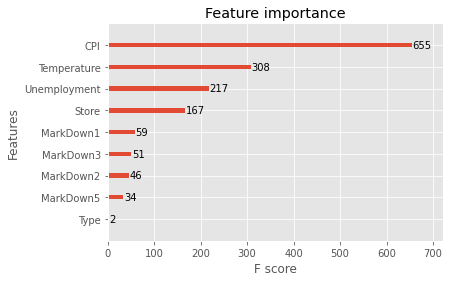

In [70]:
xgb.plot_importance(bst)

In [71]:
#MAE
mae = mean_absolute_error(y_test, ypred)
print(f'Mean absolute error: {mae}')

Mean absolute error: 0.10181715825310451


In [72]:
#RMSE
mse = mean_squared_error(y_test,ypred)
print(f'Root mean squared error: {np.sqrt(mse)}')

Root mean squared error: 0.11979776321919101


In [73]:
# RMSE Naive aproach
np.sqrt(np.sum((ypred-np.mean(y_test))**2)/len(ypred))

0.19554375415410927